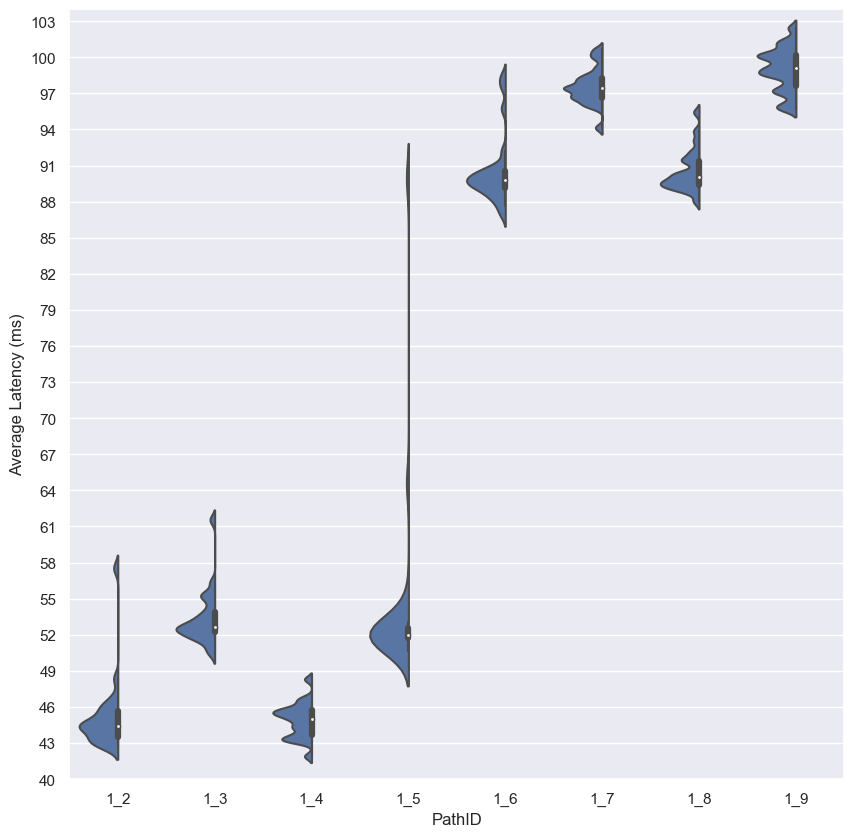

In [84]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\Test Suite\\SCION-Test-Suite\\Backup Data\\Backup Data SCIONLab.json") as f:
    data = json.load(f)

# Convert pymongo cursor to a list of dictionaries
# data = list(documents)

# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

sns.violinplot(
    data=df, x="_id", y="avg_latency",
    hue=True,
    hue_order=[True, False], split=True,
    bw = 0.18,
    scale = "count",
).legend_ = None
custom_ticks = []
for i in range(40, 105, 3):
    custom_ticks.append(i)

sns.set(rc={"figure.figsize":(5, 15)})
plt.yticks(custom_ticks, [str(tick) for tick in custom_ticks])  # Set the custom ticks
plt.ylabel("Average Latency (ms)")
plt.xlabel("PathID")
plt.ylim([40.0,104.0])
plt.show()

In [ ]:
df['avg_bandwidth_cs_64'] = pd.to_numeric(df['avg_bandwidth_cs_64'].str.replace('Mbps', ''))
df['avg_bandwidth_cs_MTU'] = pd.to_numeric(df['avg_bandwidth_cs_MTU'].str.replace('Mbps', ''))
df['avg_bandwidth_sc_64'] = pd.to_numeric(df['avg_bandwidth_sc_64'].str.replace('Mbps', ''))
df['avg_bandwidth_sc_MTU'] = pd.to_numeric(df['avg_bandwidth_sc_MTU'].str.replace('Mbps', ''))


In [86]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_theme()
with open("C:\\Users\\maxbr\\Desktop\\Polito\\Thesis SCION\\Test Suite\\SCION-Test-Suite\\Backup Data\\Backup Data SCIONLab.json") as f:
    data = json.load(f)

# Convert pymongo cursor to a list of dictionaries
# data = list(documents)

# # Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df['avg_latency'] = pd.to_numeric(df['avg_latency'].str.replace('ms', ''))
df['_id'] = df['_id'].apply(lambda x: re.sub(r'_(\d{4}-\d{2}-\d{2}).*|-\d{2}:\d{2}:\d{2}\.\d{6}|_$', '', x))

# ordered_ids = df['_id'].value_counts().index
# g = sns.FacetGrid(df, row="_id", row_order=ordered_ids, height=5, aspect=2)

# g.map(sns.histplot, "avg_latency")

# custom_ticks = []
# for i in range(40, 105, 3):
#     custom_ticks.append(i)

# sns.set(rc={"figure.figsize":(15, 15)})
# plt.yticks(custom_ticks, [str(tick) for tick in custom_ticks])  # Set the custom ticks
# plt.ylabel("Average Latency (ms)")
# plt.xlabel("PathID")
# plt.ylim([40.0,104.0])
# plt.show()
print(df)

     _id  avg_latency avg_bandwidth_cs_64 avg_bandwidth_sc_64  \
0    1_2    48.352667            0.36Mbps            2.61Mbps   
1    1_3    52.552000            0.59Mbps            2.77Mbps   
2    1_4    44.614000            0.59Mbps            2.43Mbps   
3    1_5    52.432667            0.31Mbps            2.95Mbps   
4    1_6    88.308000            0.48Mbps            2.42Mbps   
..   ...          ...                 ...                 ...   
186  1_5    51.787000            0.42Mbps            2.64Mbps   
187  1_6    90.442333            0.45Mbps            2.42Mbps   
188  1_7    98.014000            0.50Mbps            2.16Mbps   
189  1_8    88.025333            0.39Mbps            2.49Mbps   
190  1_9    95.802000            0.41Mbps            2.64Mbps   

    avg_bandwidth_cs_MTU avg_bandwidth_sc_MTU avg_loss  \
0               5.64Mbps             2.30Mbps       0%   
1               5.22Mbps             1.71Mbps       0%   
2               5.32Mbps             1.64Mbps

In [94]:
import matplotlib.pyplot as plt

Error in callback <function _draw_all_if_interactive at 0x000002304CB32340> (for post_execute):


KeyboardInterrupt: 

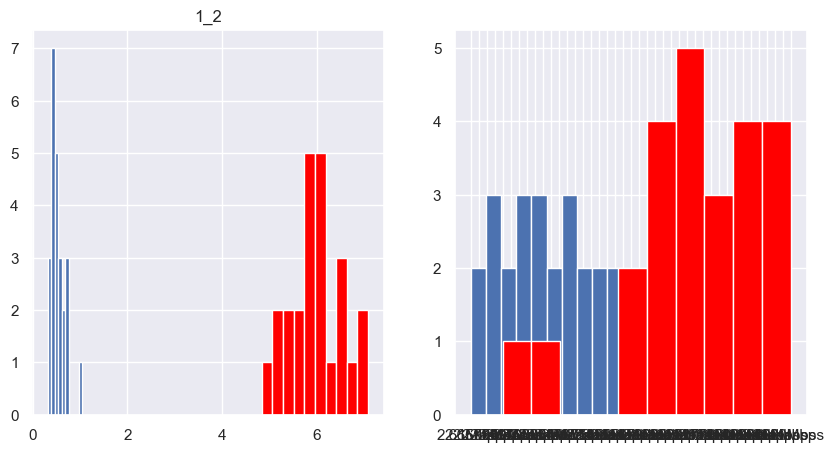

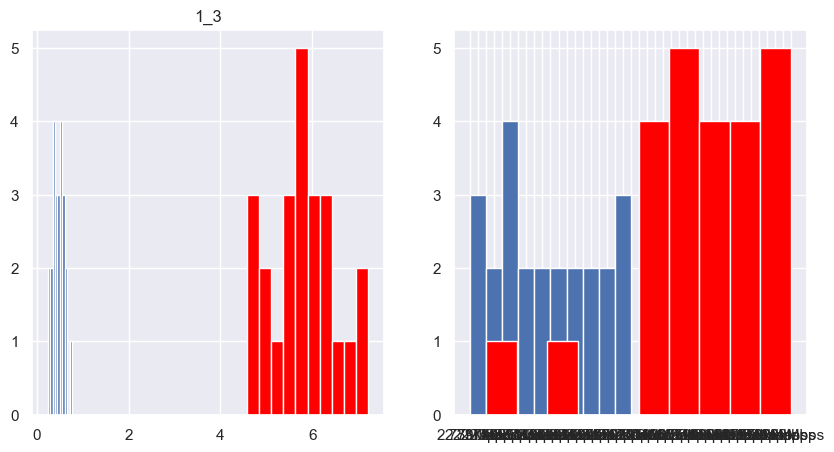

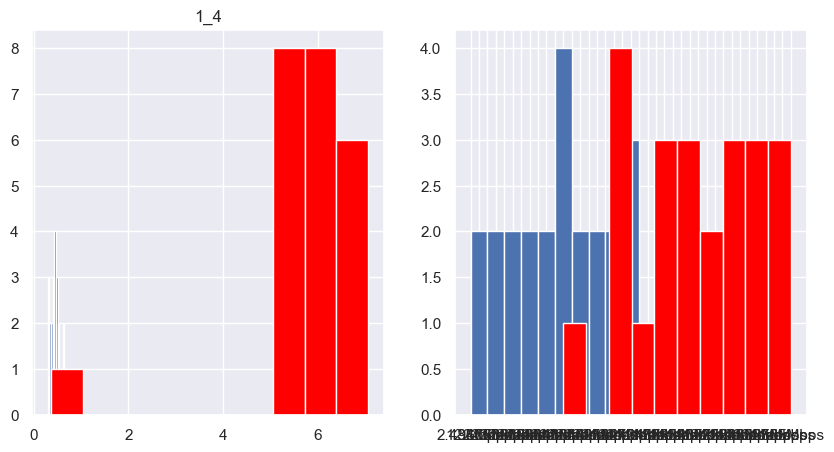

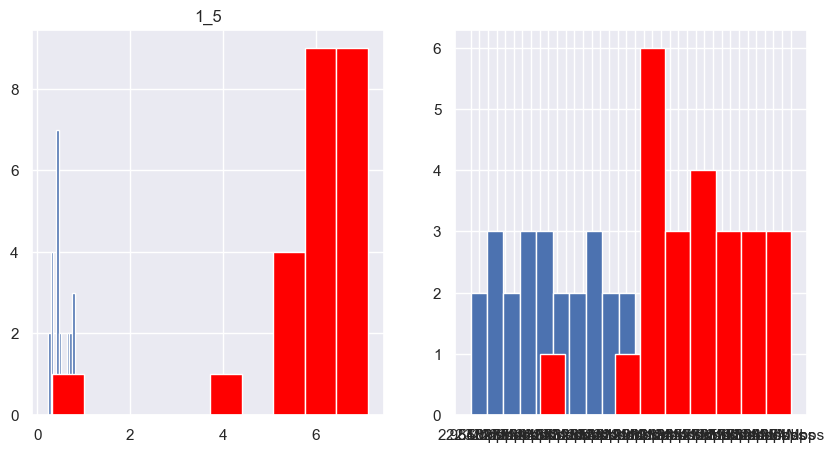

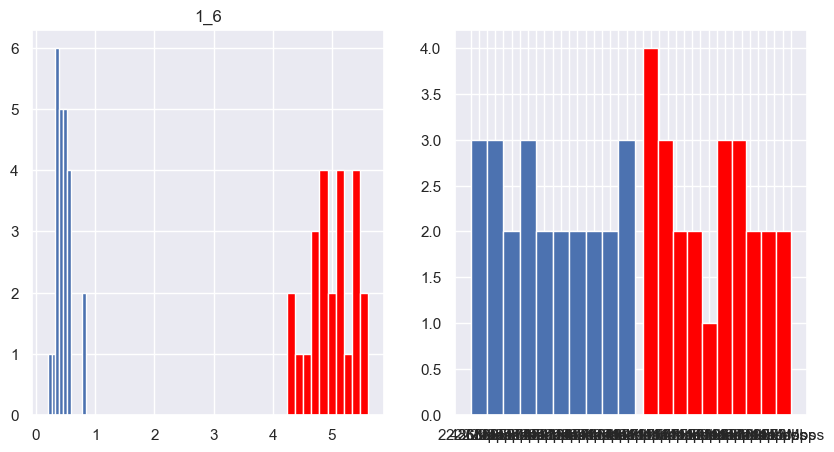

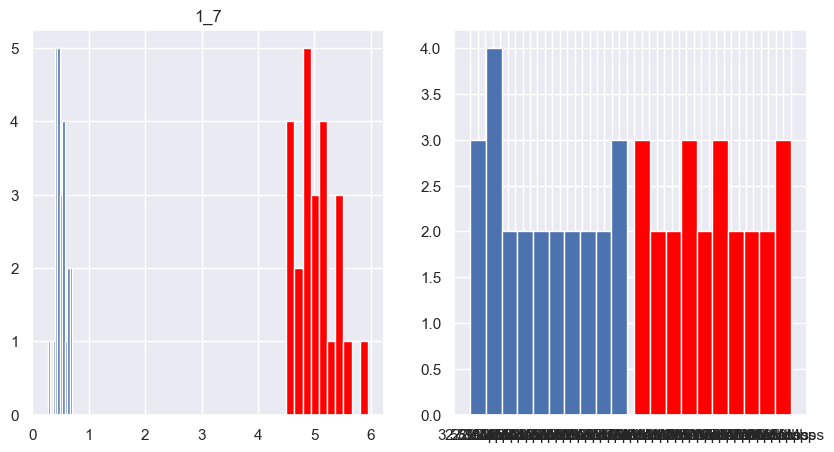

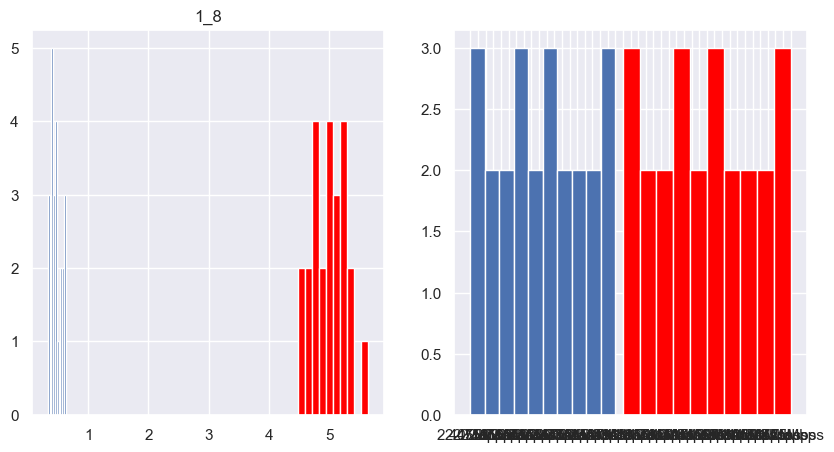

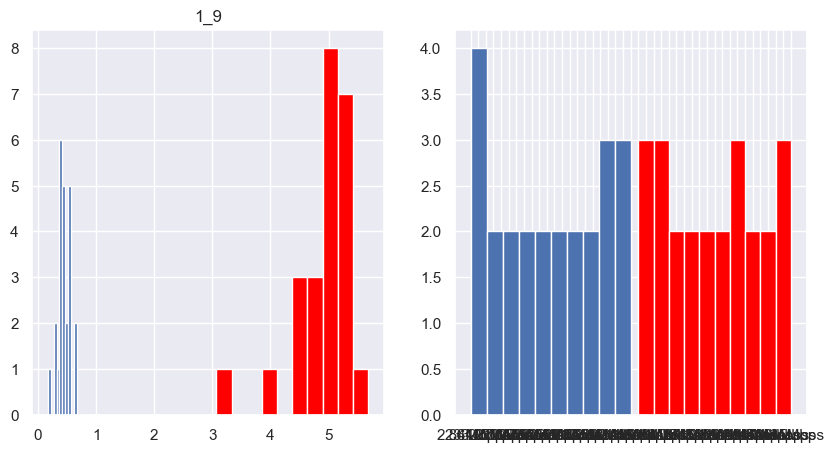

In [118]:
for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, (ax, bx) = plt.subplots(1,2, figsize=(10,5))
    ax.hist(d['avg_bandwidth_cs_64'])
    ax.hist(d['avg_bandwidth_cs_MTU'], color='red')
    bx.hist(d['avg_bandwidth_sc_64'])
    bx.hist(d['avg_bandwidth_sc_MTU'], color='red')
    ax.set_title(id)

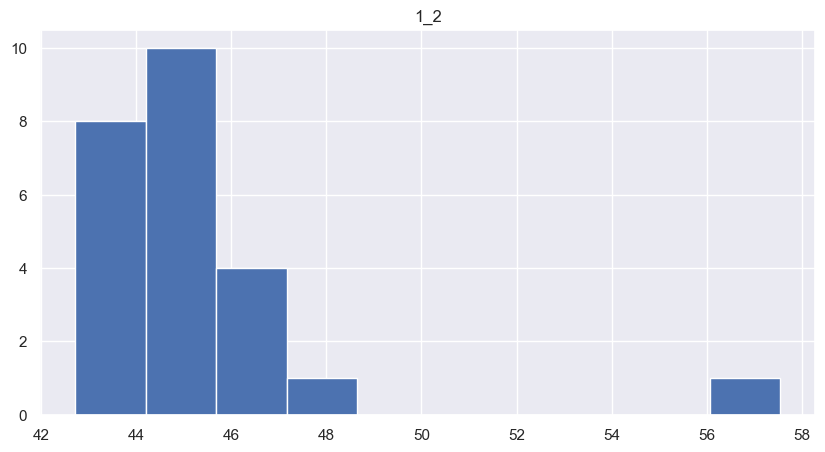

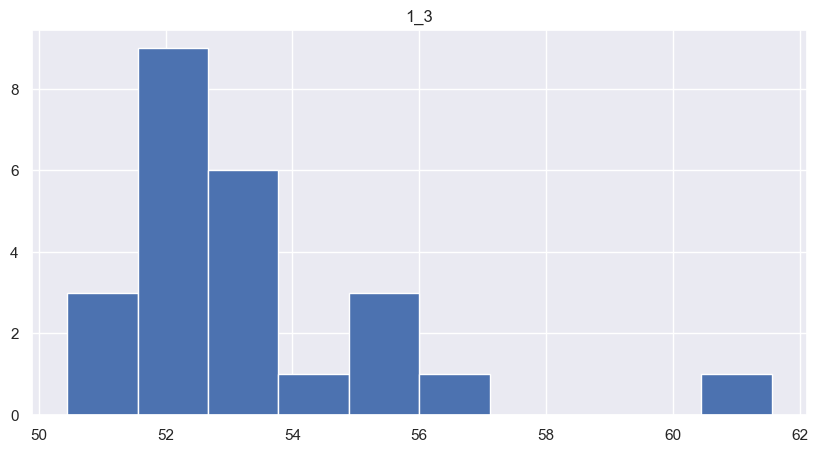

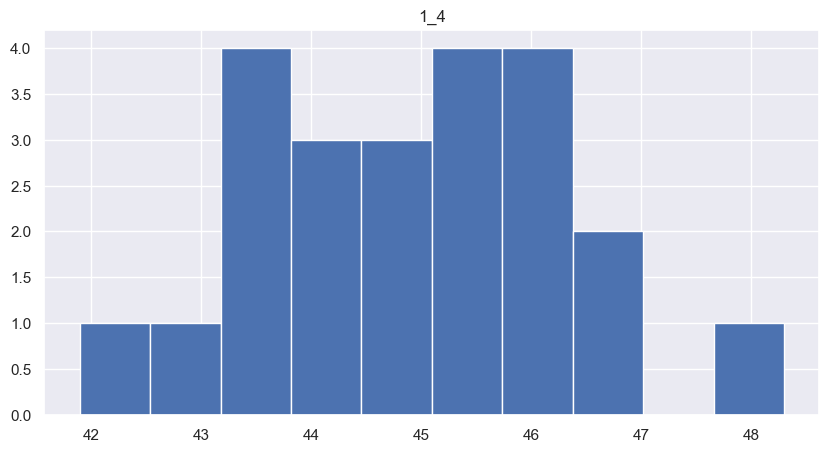

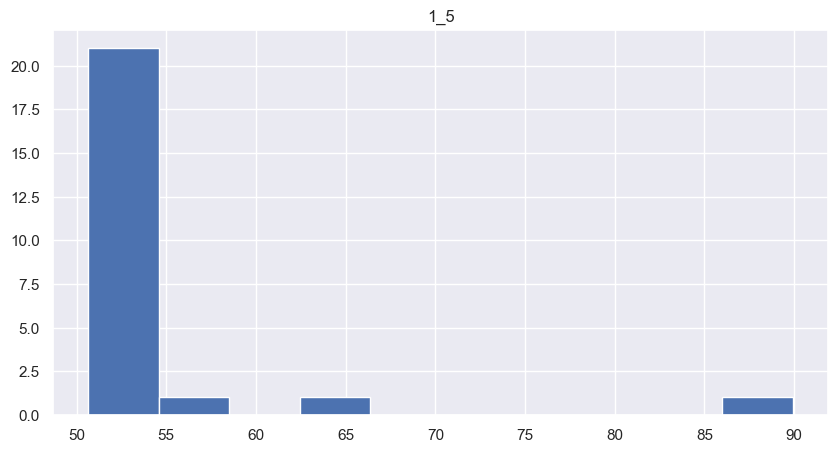

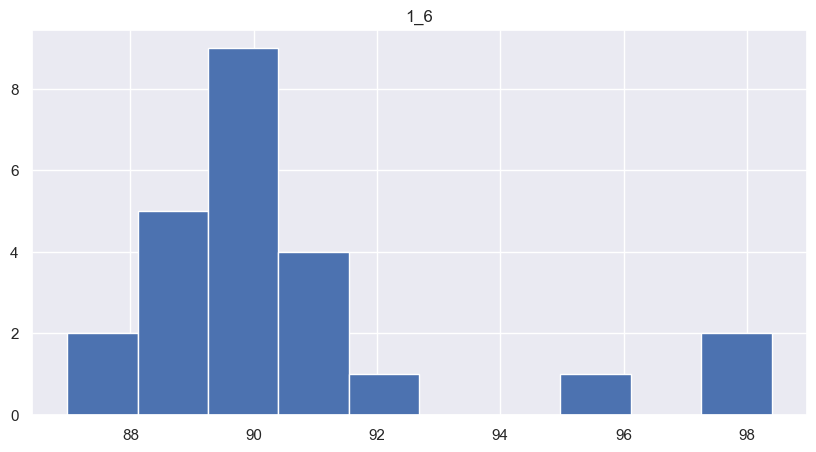

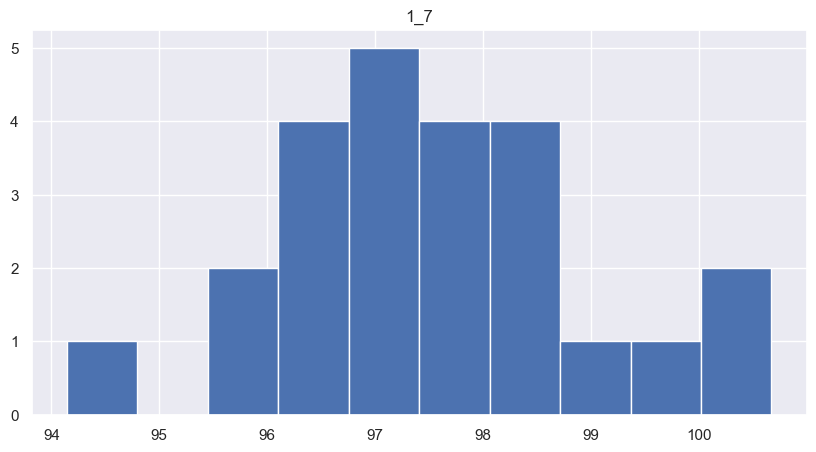

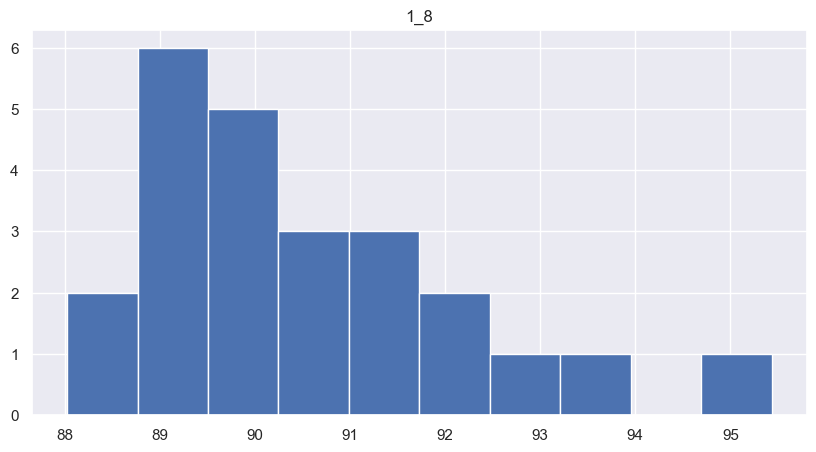

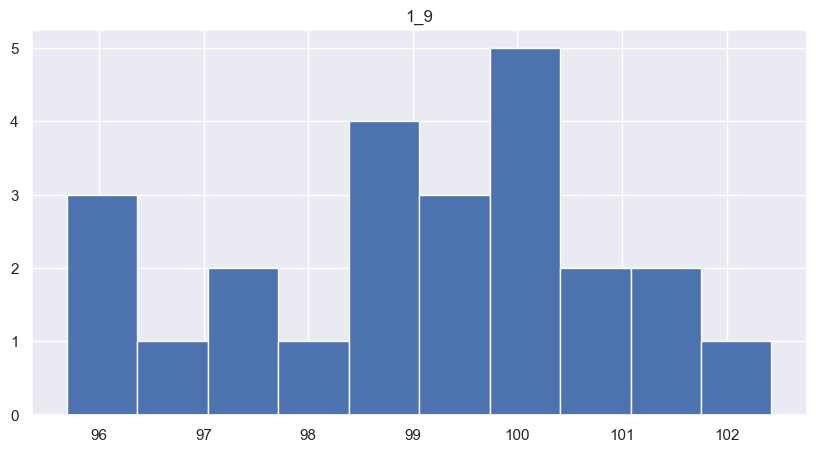

In [107]:
for id in df['_id'].unique():
    d = df[df['_id'] == id]
    f, ax = plt.subplots(1,1, figsize=(10,5))
    ax.hist(d['avg_latency'])
    ax.set_title(id)
    # sns.violinplot(d, hue_order=[True, False], split=True, ax=ax, orient='h')
